# Assignments - module 1

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vigji/python-cimec/blob/main/assignments/Assignments_1.ipynb)

This notebook contains the assignments to complete for credits for the first module.

**Submission**: Once you're happy with your solutions, send it to me in any form (email the file, share it through Colab/Google Drive, send me a link to your GitHub repo...).

**Deadline**: 15th of July 2023

**Evaluation**: There is no grade, but I will pass assignments that showcase a reasonable degree of understanding og the covered topics. Do your best, and feel free to ask for help if you are struggling!

(Also, try to keep in mind not only the goal of the exercise, but also all the coding best practices we have been considering in the lectures.)

## 0. Spike detection

In this exercise we will be playing around with some (dummy) electrophysiology recordings. Let's start by having a look at the raw data!

In [ ]:
def generate_spike_trace(trace_length=60, firing_rate=1, noise_sigma = 0.05):
    """Function to generate a fake extracellular recording.

    Parameters
    ----------
        trace_length : float
            Duration of the recording in seconds.

        firing_rate : float
            Average firing rate of the neuron in Hz.

        noise_sigma : float
            Noise level.


    Returns:
    --------
        np.array
            Fake extracellular recording.

    """
    np.random.seed(42)
    FS = 10000  # sampling frequency
    n = int(trace_length * FS)  # number of samples

    # Generate spike shape template as a difference of Gaussians.
    # A horrible bunch of magic numbers - do not imitate!
    x = np.arange(30)
    spike_template = np.exp(-(x - 10)**2/6) - np.exp(-(x - 12)**2/16)*0.8

    # Generate spike times from a gaussian distribution:
    spikes_times = np.random.poisson(firing_rate / FS, n)

    # Convolve dirac delta functions of spike times with spike template:
    trace = np.convolve(spikes_times, spike_template)[:n]

    # Add some gaussian noise:
    trace += np.random.normal(0, noise_sigma, n)

    return trace

### Exercise 0.0

Run the function below to generate an synthetic extracellular recording for a neuron. Make a nice plot with the trace; the spikes are the peaks appearing above the noise!

---

(_Optional_) If you want to make a plot with exact x coordinates in seconds, you should know that the trace is sampled at 10000 Hz (10000 points per second).

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'synthetic extracellular recording - single neuron')

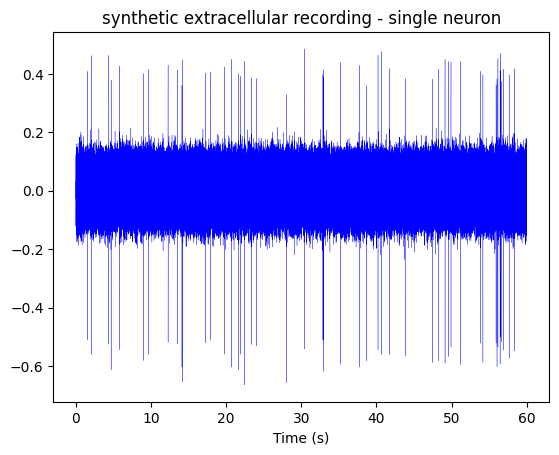

In [ ]:
spike_trace = generate_spike_trace()
sampling_rate = 10000 #Hz

seconds = len(spike_trace)/sampling_rate  #Secondi di recoding

seconds_axisX = np.linspace(0,seconds, num = len(spike_trace))  #x axis
plt.plot(seconds_axisX, spike_trace, 'blue', linewidth = 0.2)

plt.xlabel('Time (s)')
plt.title('synthetic extracellular recording - single neuron')

### Exercise 0.1

Write a function to detect spikes!
The function should take the trace as input, and return the index of each spike as the output (as the index, you should take the position of the spike maximum)

Hint: a good strategy to detect such events is to set a threshold, and look for elements above it. This will not be enough! each spike could have more than 1 point above the threshold, but you want to make sure you take only the spike peak! For this, you will probably need a loop.

Hint: do not start from writing the function. First debug your code running it in a cell, then move it to a function.

Hint: if you want, you can quickly check out the results you are getting by making a scatter plot of the detected spikes overimposed on the electrophysiology trace! (use as x of the dots the indexes of the spikes, and as y the hight of the trace at those indexes)

In [ ]:

def peaks_buster(data):
  """ Function for finding peaks
      peaks = magnitude of the peak - y value
      idx_peaks = when that peaks happened - x value  """

  THR = 0.25 #threshold
  peaks = []
  idx_peaks = []

  past_point = 0 #

  for idx, value in enumerate(data):

    if idx == 0:
      past_point = 0
    else:
      past_point = data[idx-1]

    actual_point =  value       # datapoint preso in esame ora
    if idx < (len(data)-1):   # controllare che non siamo arrivati alla fine di data
      next_point = data[idx+1]
    else:
      next_point = 0            # ultimo datapoint

    if  (actual_point > THR) & (actual_point > next_point) & (actual_point > past_point) :  #controllare se supera THR ed è effettivamente più alto dei 2 punti vicini
      peaks.append(value)
      idx_peaks.append(idx)

  return peaks, idx_peaks



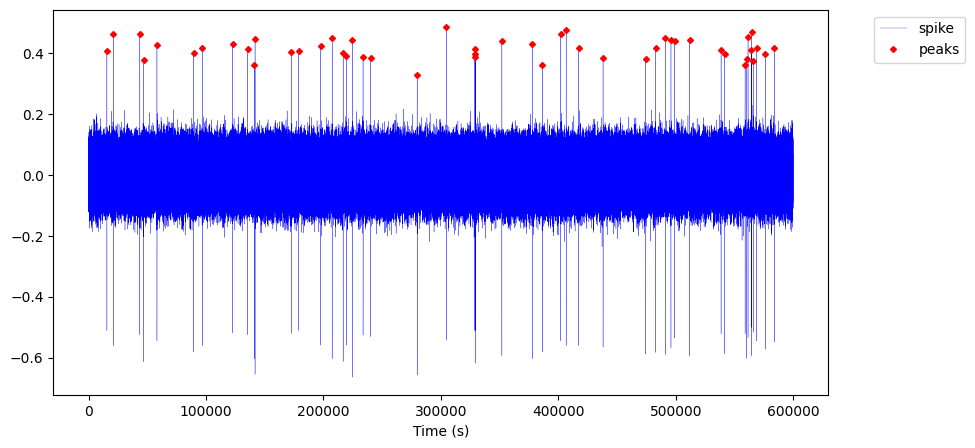

In [ ]:
peaks, idx_peaks = peaks_buster(spike_trace)

plt.figure(figsize=(10, 5))
plt.plot(spike_trace, 'blue', linewidth = 0.2)
plt.plot(idx_peaks, peaks, 'rD', markersize = 3)

plt.xlabel('Time (s)')
plt.legend(['spike', 'peaks'],bbox_to_anchor=(1.05, 1), loc='upper left')

### Exercise 0.2

We now want to have a look at the shape of those spikes. For this, we will create a function that crops small chunks of the trace around each spike peak.

Write a `crop_event()` function that takes as inputs:
   - the recording array
   - the spike indexes
   - a `n_points_pad` variable specifying the number of points to include before and after the spike

And returns a matrix of shape `(n_spikes, n_points*2)` containing the trace chunks cropped around spike events!

Hint: A good strategy coult be initialize an empty matrix and then fill it in a loop with the trace around the spikes.

**This function can be very useful in many contexts!** You can use it every time you want to crop a timeseries around events (e.g., EEG data or video kinematics data around some stimuli). So keep it at hand in the future!

---

(_Optional_) Pro challenge: Try to do it without for loops! if you construct a matrix with the indexes of the points you want to exctract from the trace, you can use it directly to index the trace!
For indexing in this way, you want to build a matrix that looks like this:
```
array([[...t0-2, t0-1, t0, t0+1, t0+2...],
       [...t1-2, t1-1, t1, t1+1, t1+2...],
       [...t2-2, t2-1, t2, t2+1, t2+2...],])
```
Where `t0`, `t1`, `t2`... are the indexes of each spike, and you take as many points before and after as specified by the `n_points_pad` paramenter.

Building this matrix without loops is not trivial but it can be done nicely with numpy broadcasting!

In [ ]:
n_points_pad = 3

def crop_event(spike_trace, idx_peaks, n_points_pad):
  """ spike_trace = data to crop
      idx_peaks = when the peaks happened
      n_points_pad = how many data points after and before each peak you want to crop
  """

  real_n_points_pad = (n_points_pad*2)+1    #se n_points_pad = 3, vuol dire da -3 a +3, a step di 1, quindi 7 step
  chunks_peaks = np.zeros((len(idx_peaks), (n_points_pad*2))) #matrice vuota

  points_close_peaks_float = np.linspace(n_points_pad , (n_points_pad*-1), num = real_n_points_pad)
  points_close_peaks = points_close_peaks_float.astype(int)  #conversione da float ad integer

  #Se non voglio far comparire nel crop anche il valore originale, devo rimuovere lo zero da "points_close_peaks"
  mask_zero = (points_close_peaks!=0)  #mask per selezionare tutto ciò che non è zero
  points_close_peaks = points_close_peaks[mask_zero]  #rimuovere zero
  #print(points_close_peaks)

  for idx , value_spike in enumerate(idx_peaks):
    for idx_point , value_point in enumerate(points_close_peaks):
      spike_to_grab = (value_spike - value_point)
      chunks_peaks[idx, idx_point] = spike_trace[spike_to_grab]

      #print(spike_to_grab) #i 3 spike precedenti e poi i 3 che seguono

  return(chunks_peaks)

In [ ]:
cropped_data = crop_event(spike_trace,idx_peaks,3)
cropped_data

array([[-1.78486406e-02,  8.01264891e-02,  1.91094606e-01,
         3.35662575e-01,  6.46069767e-02, -3.66589252e-01],
       [ 8.32328279e-02,  5.82903999e-02,  2.26409737e-01,
         3.85400593e-01,  5.03282996e-02, -2.56692017e-01],
       [-1.49288591e-01,  1.25502635e-02,  1.26456912e-01,
         4.25336046e-01,  8.00126485e-02, -2.53574122e-01],
       [-4.85602252e-02,  6.45559649e-02,  2.39265920e-01,
         3.26242197e-01,  9.36180443e-02, -3.29823577e-01],
       [ 1.43247852e-01,  2.30827146e-01,  3.44258120e-01,
         1.61075637e-01, -2.96351578e-01, -5.39207809e-01],
       [ 1.66044232e-02,  1.86292726e-01,  3.24192375e-01,
         9.21233179e-02, -3.05754906e-01, -5.32135083e-01],
       [ 2.24363095e-02,  2.38320475e-01,  3.75522216e-01,
         1.51106104e-01, -3.15826819e-01, -5.33826276e-01],
       [ 7.89954194e-02,  1.35148877e-02,  2.35088788e-01,
         3.58239459e-01,  1.24173169e-01, -2.63195155e-01],
       [-6.33697255e-02,  1.89747004e-01,  3.208

### Exercise 0.3

Finally, make two subplots one close to the other. On the left, use `plt.matshow` to show the spike matrix. On the right,
plot each individual spike (rows of the matrix) using `plt.plot` with gray lines, and the average spike shape in red on top.

---

(Optional) If you want you can try to normalize the matrix before plotting by subtracting the average of each row (as we were doing for the daily temperatures)!

[Text(0.5, 1.0, 'individual and mean spike')]

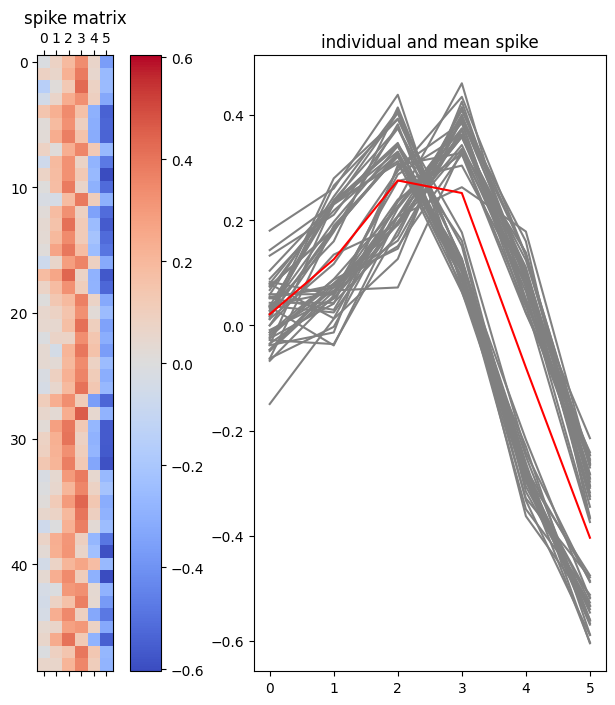

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 8)) # create two subplots

# primo subplot
im = axes[0].matshow(cropped_data)  #spike matrix
cbar = fig.colorbar(im, ax=axes[0])
axes[0].set(title = 'spike matrix')

im.set_cmap('coolwarm')
max_value_spike= np.max(np.abs(cropped_data))
im.set_clim(vmin=-max_value_spike, vmax=max_value_spike)  #mettiamo lo stesso range per la colormap

# second subplot
for row in cropped_data:
  axes[1].plot(row, color = 'grey')   # individual spike

column_means = np.mean(cropped_data, axis = 0)
axes[1].plot(column_means, color = 'r')   # mean spike
axes[1].set(title = 'individual and mean spike')


## 1. Real books data

After having appreciated how many books the universe of all possible books contains, let's now focus just on the reachable ones - and how much people like them!

Here, we will download the information about about thousands volumns available on Amazon. Just a tiny fraction of Babel's books, but way more organized!

We will also get a dataset of users writing reviews, and a dataset of reviews.

### Exercise 1.0

Using, `pandas`, read the `.csv` files containing the books, the ratings, and the user data that you can find at the  urls defined below.

Then, plot an histogram of all the ratings from all users, and another histogram with the age of the users:

In [ ]:
users_df_url = "https://github.com/vigji/python-cimec/raw/main/assignments/files/users.csv"
ratings_df_url = "https://github.com/vigji/python-cimec/raw/main/assignments/files/ratings.csv"
books_df_url = "https://github.com/vigji/python-cimec/raw/main/assignments/files/books.csv"


[Text(0.5, 0, 'year'), Text(0.5, 1.0, 'Age')]

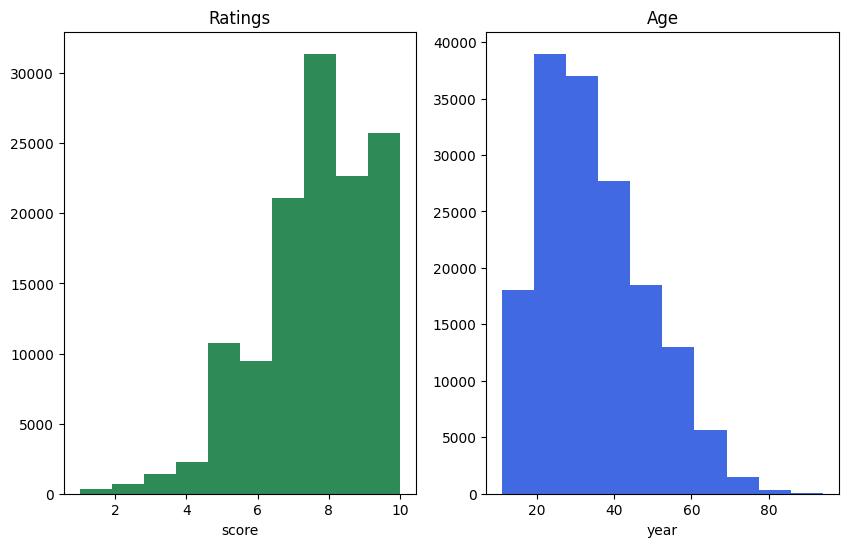

In [ ]:
users = pd.read_csv(users_df_url)
ratings = pd.read_csv(ratings_df_url)
books = pd.read_csv(books_df_url)

fig, ax = plt.subplots(1, 2, figsize = (10, 6))

#Ratings
ax[0].hist(ratings['rating'], color = 'seagreen')
ax[0].set(xlabel = "score", title = "Ratings")

#Age
ax[1].hist(users['age'] , color = 'royalblue')
ax[1].set(xlabel = "year", title = "Age")

### Exercise 1.1

Using the ratings dataframe, compute the average rating for each book, and count how many reviews each book had. Then:
- find out which book had the highest number of reviews.
- find out which book had the highest average rating - but include only books that have at least 100 reviews!


Finally, look for the titles that correspond to those book codes (ISBNs are unique book codes).

In [ ]:
book_counts = ratings['ISBN'].value_counts()

#highest number of review
N_review = book_counts.max()
most_reviewed_ISBN = book_counts.idxmax()

#Given ISBN code, find the title in books dataframe
mask = books['ISBN']==most_reviewed_ISBN
title_most_reviewed_book = books.loc[mask , 'title'].values[0]  #Non ho ben capito perchè debba usare anche .values[0] in modo da selezionare solo il titolo. Se non lo faccio title_most_reviewed_book mi riporta anche la riga del dataframe in cui c'è quel codice ISBN

print(f"The most reviewed book is '{title_most_reviewed_book}', with {N_review} reviews. Its ISBN code is {most_reviewed_ISBN} ")

The most reviewed book is 'Wild Animus', with 459 reviews. Its ISBN code is 0971880107 


In [ ]:
avg_rating = ratings.groupby('ISBN').mean()

#Top book with highest avg rating - we don't care about "mattone polacco minimalista di scrittore morto suicida giovanissimo" with less then 100 reviews
mask_book_100 = book_counts.loc[book_counts > 100]
book_100 = avg_rating.iloc[mask_book_100]

highest_avg_rating = book_100['rating'].max()
highest_avg_rating_ISBN = book_100['rating'].idxmax()

#Given ISBN code, find the title in books dataframe - same code as above
mask2 = books['ISBN']==highest_avg_rating_ISBN
title_top_book = books.loc[mask2 , 'title'].values[0]

print(f"The book with the highest average is '{title_top_book}'. Its ISBN code is {highest_avg_rating_ISBN} ")

The book with the highest average is 'Abhorsen (The Abhorsen Trilogy)'. Its ISBN code is 0060278250 


### Exercise 1.2

Let's get even more specific! Let's find the preferences of users in specific countries and with different ages.

Use the users DataFrame to select only italian users under 40 years old. Then, go back to the reviews dataframe and filter only reviews from those users. Compute the average ratings (include only books that have at least 3 reviews) and sort the ISBNs by average rating. Finally, find the books corresponding to each ISBN code to get which books got the best ratings in this coort of people!

(_Optional_): from the users DataFrame generate a list of all the countries present in the dataset. Then, find the highest rated book in each one of those countries.

In [ ]:
#Italians under 40
mask_young_italians = (users['country'] == "italy") & (users['age'] < 40)
young_italians = users.loc[mask_young_italians ]

#Italians' ratings under 40
mask_italians_ID = ratings['user_id'].isin(young_italians['user_id'])
ratings_italians_all = ratings[mask_italians_ID]

N_reviews_ita_all = ratings_italians_all['ISBN'].value_counts()   #libri con codice ISBN e corrispondenti review da italians
N_reviews_ita = N_reviews_ita_all.loc[N_reviews_ita_all > 2]   #teniamo solo i libri con almeno 3 review

mask = ratings_italians_all['ISBN'].isin(N_reviews_ita.index)
ratings_italians = ratings_italians_all.loc[mask]   #singole review, tenendo però solo le review per libri con almeno 3 review. Ho già detto review?


In [ ]:
avg_ratings_italians = ratings_italians.groupby('ISBN').mean()  #media recensioni per ogni libro
ranking_books = avg_ratings_italians.sort_values(by= 'rating' , ascending=False) #Dal più alto al più basso in termini di media

#Dal dataframe books prendere i libri che corrispondono al codice ISBN
mask_books = books['ISBN'].isin(ranking_books.index)
top_book_italy = books.loc[mask_books, :]

top_book_italy

,ISBN,title,author
202,0060977493,The God of Small Things,Arundhati Roy
811,0743222229,George W. Bushisms : The Slate Book of The Acc...,Jacob Weisberg
1325,0385335482,Confessions of a Shopaholic (Summer Display Op...,SOPHIE KINSELLA
1731,881787017X,Senza Sangue,Alessandro Baricco
2385,880781210X,iI Paradiso Degli Orchi,Daniel Pennac
3209,8806143042,Almost blue (Stile libero),Carlo Lucarelli
5225,8817131628,Garzanti - Gli Elefanti: Gabbiano Jonathan Liv...,Bach
5253,8817106259,Seta,Alessandro Baricco
5267,884590184X,Siddharta Romanzo Versione Di M Mila,Hermann Hesse
5619,8804375914,Il sentiero dei nidi di ragno (Oscar Mondadori),Italo Calvino


In [ ]:
foo_df = pd.merge(top_book_italy, ranking_books , on = 'ISBN') #Uniamo il dataframe dei top book italy, con i rispettivi rating

#Voglio vedere anche quante recensioni ha ogni singolo libro
df_N_review = pd.DataFrame({'N_review':N_reviews_ita})  #prendi "N_review_ita" e convertilo in un dataframe
df_N_review['ISBN'] = df_N_review.index   #prendi i suoi index (che sono i codici ISBN) e aggiungilo in una nuova colonna di value

#Findal df con libri, relativa media recensioni, e numero di review
final_df = pd.merge(foo_df, df_N_review , on = 'ISBN')
final_df = final_df.drop (columns = ['ISBN' , 'user_id'])  #Facciamo un pò di pulizia
final_df = final_df.sort_values(by= 'rating' , ascending=False)
final_df

,title,author,rating,N_review
18,Il Piccolo Principe,Antoine De Saint-Exupery,9.500000,4
17,Il Piccolo Principe Prince Italn,Antoine de Saint-ExupÃ©ry,9.272727,11
28,Se questo e un uomo ; La tregua,Primo Levi,9.000000,3
22,Writer's Notebook,Running Press,9.000000,3
0,The God of Small Things,Arundhati Roy,8.666667,3
29,La Prosivendola,Daniel Pennac,8.666667,3
16,"Novocento, Un Monologo",Alessandro Baricco,8.583333,12
5,Almost blue (Stile libero),Carlo Lucarelli,8.500000,6
14,Oceano Mare,Alessandro Baricco,8.454545,11
23,Le Ceneri Di Angela,McCourt,8.333333,3
